## Prueba #0502

### "Reconocimiento de actividad humana" 

#### Responda las siguientes preguntas proporcionando código Python:
#### Objetivos:
- Realizar la EDA.
- Realizar el preprocesamiento de los datos.
- Optimice y pruebe un modelo predictivo de su elección.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics, preprocessing
warnings.filterwarnings(action='ignore')                  # Desactivar las advertencias.
%matplotlib inline

#### Leer los datos:
La explicación sobre el conjunto de datos se puede encontrar [aquí](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

In [2]:
# Ir al directorio dónde se ecuentra el fichero 
os.chdir(r'./')                # Reemplazar por la ruta adecuada

In [3]:
df = pd.read_csv('data_human activity recognition.csv', header='infer')

In [4]:
df.shape   # 19622 observaciones, 160 características

(19622, 160)

In [5]:
df.columns # nombre de las 160 características

Index(['Unnamed: 0', 'user_name', 'raw_timestamp_part_1',
       'raw_timestamp_part_2', 'cvtd_timestamp', 'new_window', 'num_window',
       'roll_belt', 'pitch_belt', 'yaw_belt',
       ...
       'gyros_forearm_x', 'gyros_forearm_y', 'gyros_forearm_z',
       'accel_forearm_x', 'accel_forearm_y', 'accel_forearm_z',
       'magnet_forearm_x', 'magnet_forearm_y', 'magnet_forearm_z', 'classe'],
      dtype='object', length=160)

1). Realice la EDA. Compruebe los valores faltantes. SUGERENCIA: La variable de respuesta es 'clase'.

Valores posibles para la salida del data set y número de repeticiones para cada una de ellas: 
A 5580
B 3797
C 3422
D 3216
E 3607


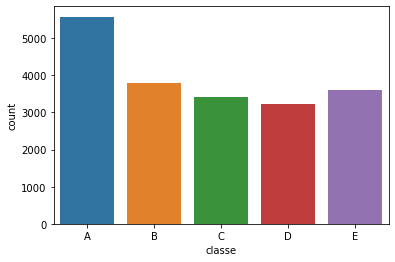

Hay valores faltantes para  100  características
Número de valores faltantes por caracterítica del dataset: 


,0
kurtosis_roll_belt,19216
kurtosis_picth_belt,19216
kurtosis_yaw_belt,19216
skewness_roll_belt,19216
skewness_roll_belt.1,19216
...,...
stddev_pitch_forearm,19216
var_pitch_forearm,19216
avg_yaw_forearm,19216
stddev_yaw_forearm,19216


In [6]:
# Comprobar las posibles salidas que tiene el dataset
salida = df['classe']
val_sal, num_rep = np.unique(salida, return_counts=True)
print('Valores posibles para la salida del data set y número de repeticiones para cada una de ellas: ')
for ind in np.arange(0, val_sal.size):
    print(val_sal[ind], num_rep[ind])

# Tabla de frecuencia de classe (variable objetivo, salida del dataset)
sns.countplot('classe',data=df)
plt.show()

# Comprobar los valores faltantes para cada característica del data set
# Suma valores perdidos del DataFrame por columnas (axis=0), por característica del data frame
num_val_falt_caract = df.isnull().sum(axis=0)
# filtrar por características para las que hay valores faltantes
caract_val_falt = num_val_falt_caract.loc[lambda x : x!=0]
print('Hay valores faltantes para ', caract_val_falt.size , ' características')
print('Número de valores faltantes por caracterítica del dataset: ')
caract_val_falt.to_frame()

2). Elimine las columnas que tengan más del 97% de valores perdidos.

In [7]:
num_obser, num_carct = df.shape 
num_obser
print('Nº observaciones del data set: ' , num_obser)

# características que se deben eliminar
caract_sup_lim_perd = np.array([])

# límite de valores faltantes por columna
lim_val_falt = np.round(num_obser*0.97)
print('Nº máximo de valores perdidos para las columnas del data set: ', lim_val_falt)

for index, value in caract_val_falt.items():
    if value > lim_val_falt:
        caract_sup_lim_perd = np.append(caract_sup_lim_perd, index)
print('Hay ' , caract_sup_lim_perd.size ,'columnas que tienen más del 97% de valores perdidos')

# Se eliminan las columnas
# axis=1 por columnas
df = df.drop(caract_sup_lim_perd, axis=1)
df.head(3)

num_obser, num_caract = df.shape 
print('Nº características del data set tras eliminar columnas con más del 97% de datos perdidos: ' , num_caract)

Nº observaciones del data set:  19622
Nº máximo de valores perdidos para las columnas del data set:  19033.0
Hay  100 columnas que tienen más del 97% de valores perdidos
Nº características del data set tras eliminar columnas con más del 97% de datos perdidos:  60


3). Elimine de las columnas innecesarias. SUGERENCIA: Aquellas columnas con "time" en el nombre y aquellas que obviamente son innecesarias.

In [8]:
# características que se deben eliminar
caract_time = np.array([])

# obtener aquellas columnas que contienen time en el nombre
for i in np.arange(0, df.columns.size):
    if ("time" in df.columns[i]):
        caract_time = np.append(caract_time, df.columns[i])     
print('Hay ', caract_time.size ,'columnas que contienen time en el nombre: ', caract_time)

# identificar aquellas columnas innecesarias: identificador y nombre
print('Hay 2 columnas innecesarias: ', df.columns[0], ' y ', df.columns[1])
caract_innec = np.append(caract_time, df.columns[0])
caract_innec = np.append(caract_innec, df.columns[1])

# Se eliminan las columnas
# axis=1 por columnas
df = df.drop(caract_innec, axis=1)

# características tras eliminar columnas innecesarias
num_obser, num_caract = df.shape 
print('Nº características del data set tras eliminar columnas innecesarias: ' , num_caract)

Hay  3 columnas que contienen time en el nombre:  ['raw_timestamp_part_1' 'raw_timestamp_part_2' 'cvtd_timestamp']
Hay 2 columnas innecesarias:  Unnamed: 0  y  user_name
Nº características del data set tras eliminar columnas innecesarias:  55


4). Codifique la etiqueta de la variable de respuesta. SUGERENCIA: use preprocessing.LabelEncoder ().

In [9]:
# Transformador para codificar valores objetivo
label_encoder = preprocessing.LabelEncoder()
# Incluir las etiquetas codificadas en el df
df['classe_cod'] = label_encoder.fit_transform(df['classe'])
# vble salida
Y = df.classe_cod
df

,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,...,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe,classe_cod
0,no,11,1.41,8.07,-94.4,3,0.00,0.00,-0.02,-21,...,0.00,-0.02,192,203,-215,-17,654.0,476.0,A,0
1,no,11,1.41,8.07,-94.4,3,0.02,0.00,-0.02,-22,...,0.00,-0.02,192,203,-216,-18,661.0,473.0,A,0
2,no,11,1.42,8.07,-94.4,3,0.00,0.00,-0.02,-20,...,-0.02,0.00,196,204,-213,-18,658.0,469.0,A,0
3,no,12,1.48,8.05,-94.4,3,0.02,0.00,-0.03,-22,...,-0.02,0.00,189,206,-214,-16,658.0,469.0,A,0
4,no,12,1.48,8.07,-94.4,3,0.02,0.02,-0.02,-21,...,0.00,-0.02,189,206,-214,-17,655.0,473.0,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19617,no,864,147.00,-34.80,129.0,21,0.37,-0.02,-0.67,50,...,-1.75,-0.25,-271,-68,-37,-205,-587.0,6.0,E,4
19618,no,864,145.00,-35.30,130.0,19,0.39,-0.02,-0.67,47,...,-1.36,0.00,-271,-91,-43,-151,-635.0,-36.0,E,4
19619,no,864,145.00,-35.50,130.0,19,0.37,0.00,-0.64,47,...,-1.20,0.05,-263,-99,-45,-116,-654.0,-70.0,E,4
19620,no,864,143.00,-35.90,131.0,18,0.37,-0.02,-0.59,46,...,-0.90,0.05,-270,-141,-51,-68,-678.0,-98.0,E,4


5). Realizar escalado min-max de las variables exploratorias. SUGERENCIA: utilice preprocesamiento.MinMaxScaler ().

In [10]:
# codificar vble new_window para aplicar escalado min-max
df['new_window'] = label_encoder.fit_transform(df['new_window'])
# Transformador escalado min-max
scaler = preprocessing.MinMaxScaler()
# obtener datos del dataset, se eliminan las columnas correspondientes a la salida original y a la salida codificada
X = df.drop(columns=['classe', 'classe_cod'])
# transformar vbles
X = scaler.fit_transform(df.drop(columns=['classe', 'classe_cod']))

6). Elija un algoritmo y realice el análisis predictivo.
- Optimizar el (los) hiperparámetro (s)
- Calcule la precisión.
- Consiga una precisión superior al 90%.

In [11]:
# Dividir datos del dataset en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

# KNeighborsClassifier --> Clasificador que implementa el voto de los k vecinos más cercanos.
knn_gs = KNeighborsClassifier()
# parámetros a optimizar
list_pos_k = np.arange(1,5,1)
parameters = {'n_neighbors':list_pos_k}

# Optimizar con GridSearch
grid_search_knn = GridSearchCV(knn_gs, parameters, cv=10, n_jobs=-1)

# Ajuste con todos los conj de parámetros
grid_search_knn.fit(X_train, y_train)

# Obtener el mejor k obtenido
dic_mejor_param = grid_search_knn.best_params_
mejor_k= dic_mejor_param['n_neighbors']
print('mejor k obtenido con GridSearch: ', mejor_k)

mejor k obtenido con GridSearch:  1


In [12]:
# Predicción GridSearchCV
y_pred_gs = grid_search_knn.predict(X_test)
y_pred_gs
print( "Accuracy con la predicción GridSearchCV: " + str(metrics.accuracy_score(y_test,y_pred_gs)))

# Predicción KNeighborsClassifier entrenado con k óptimo
knn = KNeighborsClassifier(n_neighbors=mejor_k).fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
val_accuracy_por_k = metrics.accuracy_score(y_test,y_pred_knn)
print( "Accuracy con la predicción KNeighborsClassifier para k=",mejor_k ,": " , val_accuracy_por_k)

Accuracy con la predicción GridSearchCV: 0.9751995923220655
Accuracy con la predicción KNeighborsClassifier para k= 1 :  0.9751995923220655


In [14]:
num_pred_err = 0
i = 0
for sal_esp in y_test:
    if sal_esp!=y_pred_gs[i]:
        num_pred_err += 1
    i +=1   
print("Se han obtenido", num_pred_err, "predicciones erróneas de un total de", y_test.size)

Se han obtenido 146 predicciones erróneas de un total de 5887


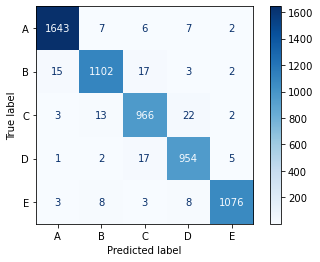

In [15]:
# Matriz de confusión
metrics.plot_confusion_matrix(knn, X_test, y_test, display_labels=val_sal , cmap=plt.cm.Blues)